# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#promt shell -> floyd run --gpu --env tensorflow-1.0 --mode jupyter --data R5KrjnANiKVhLWAkpXhNBe
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

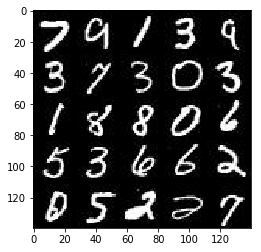

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

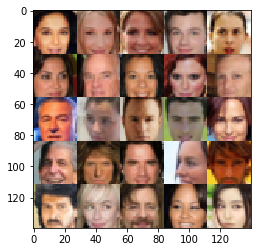

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width,image_height, image_channels], name= "inputs_real")
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name= "inputs_z")
    learning_rate = tf.placeholder(tf.float32, shape=None, name='learning_rate')
    return inputs_real, inputs_z, learning_rate
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        alpha = 0.2
        # Input layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.2
    with tf.variable_scope('generator', reuse = not is_train):
        
        x1 = tf.layers.dense(z, 14*14*512)
        x1 = tf.reshape(x1,(-1,14,14,512))
        x1 = tf.layers.batch_normalization(x1, training =  is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same') 
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')  #up sampling width an height
        x3 = tf.layers.batch_normalization(x3, training = is_train) 
        x3 = tf.maximum(alpha * x3, x3) 

        #x4 = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')  #up sampling width an height
        #x4 = tf.layers.batch_normalization(x4, training = is_train) 
        #x4 = tf.maximum(alpha * x4, x4)
        
        logits = tf.layers.conv2d(x3,  out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
        
        return out  
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    #'Without tf.control_dependencies, TensorFlow's batch normalization layer will not operate correctly 
    # during inference'
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
#from IPython.core.debugger import set_trace
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()        
    input_real, input_z, l_r = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, l_r, beta1)
    is_train = tf.placeholder(tf.bool)
    
    #saver = tf.train.Saver()
    #sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    #samples, losses = [], []
    
  
    print_every=10
    show_every=100
    steps = 0  
    batch_number = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_number += 1
                # Sample random noise for G
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, l_r:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,l_r:learning_rate,is_train:True})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,l_r:learning_rate,is_train: False})
               
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))
                    
 

                if steps % show_every == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)



### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.3232... Generator Loss: 0.0318
Epoch 1/2... Discriminator Loss: 3.8204... Generator Loss: 0.0814
Epoch 1/2... Discriminator Loss: 3.0985... Generator Loss: 0.1616
Epoch 1/2... Discriminator Loss: 2.5809... Generator Loss: 0.2568
Epoch 1/2... Discriminator Loss: 2.1637... Generator Loss: 0.3102
Epoch 1/2... Discriminator Loss: 2.0001... Generator Loss: 0.4409
Epoch 1/2... Discriminator Loss: 2.0714... Generator Loss: 0.4259
Epoch 1/2... Discriminator Loss: 2.0807... Generator Loss: 0.3971
Epoch 1/2... Discriminator Loss: 1.9187... Generator Loss: 0.3895
Epoch 1/2... Discriminator Loss: 1.7365... Generator Loss: 0.5999


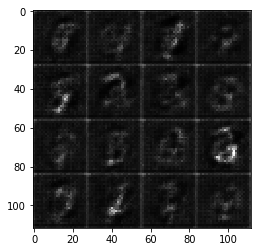

Epoch 1/2... Discriminator Loss: 1.6859... Generator Loss: 0.4257
Epoch 1/2... Discriminator Loss: 1.6275... Generator Loss: 0.6269
Epoch 1/2... Discriminator Loss: 1.6133... Generator Loss: 0.6584
Epoch 1/2... Discriminator Loss: 1.6604... Generator Loss: 0.6922
Epoch 1/2... Discriminator Loss: 1.7035... Generator Loss: 0.3214
Epoch 1/2... Discriminator Loss: 1.4661... Generator Loss: 0.6308
Epoch 1/2... Discriminator Loss: 1.5529... Generator Loss: 0.7779
Epoch 1/2... Discriminator Loss: 1.5362... Generator Loss: 0.9139
Epoch 1/2... Discriminator Loss: 1.5689... Generator Loss: 0.8894
Epoch 1/2... Discriminator Loss: 1.3346... Generator Loss: 0.6417


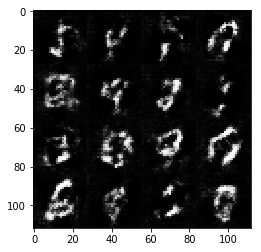

Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 0.5805
Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 0.8519
Epoch 1/2... Discriminator Loss: 1.5002... Generator Loss: 0.4503
Epoch 1/2... Discriminator Loss: 1.5416... Generator Loss: 0.4428
Epoch 1/2... Discriminator Loss: 1.5553... Generator Loss: 0.4104
Epoch 1/2... Discriminator Loss: 1.5144... Generator Loss: 0.4496
Epoch 1/2... Discriminator Loss: 1.5398... Generator Loss: 0.4128
Epoch 1/2... Discriminator Loss: 1.5155... Generator Loss: 0.4490
Epoch 1/2... Discriminator Loss: 1.5438... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 1.6001... Generator Loss: 0.6514


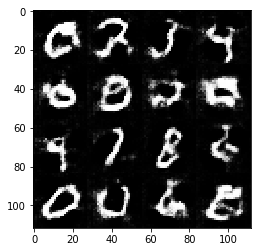

Epoch 1/2... Discriminator Loss: 1.4617... Generator Loss: 0.6288
Epoch 1/2... Discriminator Loss: 1.5090... Generator Loss: 0.5583
Epoch 1/2... Discriminator Loss: 1.5553... Generator Loss: 0.6546
Epoch 1/2... Discriminator Loss: 1.6482... Generator Loss: 0.3429
Epoch 1/2... Discriminator Loss: 1.5419... Generator Loss: 0.5446
Epoch 1/2... Discriminator Loss: 1.5030... Generator Loss: 0.7255
Epoch 1/2... Discriminator Loss: 1.6261... Generator Loss: 0.3435
Epoch 1/2... Discriminator Loss: 1.5634... Generator Loss: 0.5047
Epoch 1/2... Discriminator Loss: 1.6049... Generator Loss: 0.3904
Epoch 1/2... Discriminator Loss: 1.5657... Generator Loss: 0.4019


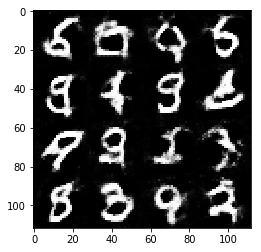

Epoch 1/2... Discriminator Loss: 1.4967... Generator Loss: 0.4660
Epoch 1/2... Discriminator Loss: 1.5026... Generator Loss: 0.5595
Epoch 1/2... Discriminator Loss: 1.4520... Generator Loss: 0.5283
Epoch 1/2... Discriminator Loss: 1.5447... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 1.4916... Generator Loss: 0.6427
Epoch 1/2... Discriminator Loss: 1.5691... Generator Loss: 0.3712
Epoch 2/2... Discriminator Loss: 1.4691... Generator Loss: 0.5697
Epoch 2/2... Discriminator Loss: 1.7326... Generator Loss: 0.2679
Epoch 2/2... Discriminator Loss: 1.5163... Generator Loss: 0.6111
Epoch 2/2... Discriminator Loss: 1.5692... Generator Loss: 0.4807


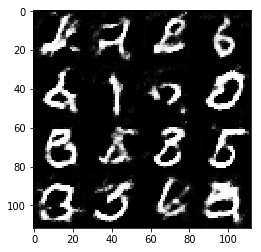

Epoch 2/2... Discriminator Loss: 1.5338... Generator Loss: 0.4220
Epoch 2/2... Discriminator Loss: 1.4779... Generator Loss: 0.9404
Epoch 2/2... Discriminator Loss: 1.5029... Generator Loss: 0.7202
Epoch 2/2... Discriminator Loss: 1.4886... Generator Loss: 0.8013
Epoch 2/2... Discriminator Loss: 1.5465... Generator Loss: 0.4501
Epoch 2/2... Discriminator Loss: 1.5306... Generator Loss: 0.4929
Epoch 2/2... Discriminator Loss: 1.4422... Generator Loss: 0.7941
Epoch 2/2... Discriminator Loss: 1.5207... Generator Loss: 0.4888
Epoch 2/2... Discriminator Loss: 1.4718... Generator Loss: 0.4946
Epoch 2/2... Discriminator Loss: 1.5572... Generator Loss: 0.6659


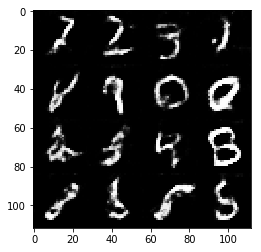

Epoch 2/2... Discriminator Loss: 1.4438... Generator Loss: 0.6957
Epoch 2/2... Discriminator Loss: 1.4313... Generator Loss: 0.7481
Epoch 2/2... Discriminator Loss: 1.5004... Generator Loss: 0.5088
Epoch 2/2... Discriminator Loss: 1.5003... Generator Loss: 0.4794
Epoch 2/2... Discriminator Loss: 1.5488... Generator Loss: 0.5140
Epoch 2/2... Discriminator Loss: 1.4292... Generator Loss: 0.6824
Epoch 2/2... Discriminator Loss: 1.5092... Generator Loss: 0.7447
Epoch 2/2... Discriminator Loss: 1.4828... Generator Loss: 0.5834
Epoch 2/2... Discriminator Loss: 1.4857... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 1.4786... Generator Loss: 0.5455


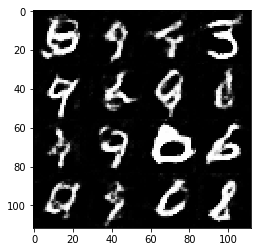

Epoch 2/2... Discriminator Loss: 1.4049... Generator Loss: 0.5360
Epoch 2/2... Discriminator Loss: 1.5271... Generator Loss: 0.7662
Epoch 2/2... Discriminator Loss: 1.4569... Generator Loss: 0.4502
Epoch 2/2... Discriminator Loss: 1.5278... Generator Loss: 0.8627
Epoch 2/2... Discriminator Loss: 1.5455... Generator Loss: 0.8694
Epoch 2/2... Discriminator Loss: 1.4548... Generator Loss: 0.6214
Epoch 2/2... Discriminator Loss: 1.4749... Generator Loss: 0.4851
Epoch 2/2... Discriminator Loss: 1.6572... Generator Loss: 0.3469
Epoch 2/2... Discriminator Loss: 1.4971... Generator Loss: 0.5927
Epoch 2/2... Discriminator Loss: 1.4828... Generator Loss: 0.5342


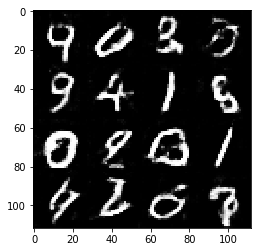

Epoch 2/2... Discriminator Loss: 1.5058... Generator Loss: 0.6204
Epoch 2/2... Discriminator Loss: 1.5236... Generator Loss: 0.4690
Epoch 2/2... Discriminator Loss: 1.4672... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 1.5894... Generator Loss: 0.3601
Epoch 2/2... Discriminator Loss: 1.5076... Generator Loss: 0.4137
Epoch 2/2... Discriminator Loss: 1.4786... Generator Loss: 0.5116
Epoch 2/2... Discriminator Loss: 1.5446... Generator Loss: 0.5170
Epoch 2/2... Discriminator Loss: 1.5474... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 1.6880... Generator Loss: 0.2873
Epoch 2/2... Discriminator Loss: 1.5116... Generator Loss: 0.8461


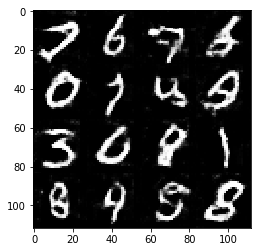

Epoch 2/2... Discriminator Loss: 1.5741... Generator Loss: 0.3920
Epoch 2/2... Discriminator Loss: 1.6434... Generator Loss: 0.3540
Epoch 2/2... Discriminator Loss: 1.5214... Generator Loss: 0.5318


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.8181... Generator Loss: 0.0664
Epoch 1/1... Discriminator Loss: 4.5324... Generator Loss: 0.0453
Epoch 1/1... Discriminator Loss: 3.6117... Generator Loss: 0.0928
Epoch 1/1... Discriminator Loss: 3.5840... Generator Loss: 0.1698
Epoch 1/1... Discriminator Loss: 3.1039... Generator Loss: 0.1848
Epoch 1/1... Discriminator Loss: 2.9260... Generator Loss: 0.2228
Epoch 1/1... Discriminator Loss: 2.4099... Generator Loss: 0.3393
Epoch 1/1... Discriminator Loss: 2.2295... Generator Loss: 0.3587
Epoch 1/1... Discriminator Loss: 2.1233... Generator Loss: 0.4252
Epoch 1/1... Discriminator Loss: 1.9554... Generator Loss: 0.4807


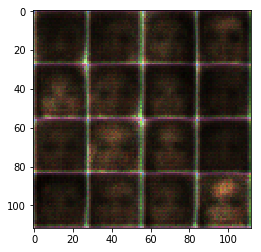

Epoch 1/1... Discriminator Loss: 1.8624... Generator Loss: 0.4567
Epoch 1/1... Discriminator Loss: 1.9464... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 1.8830... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 1.8429... Generator Loss: 0.4831
Epoch 1/1... Discriminator Loss: 1.6862... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.7886... Generator Loss: 0.5128
Epoch 1/1... Discriminator Loss: 1.8215... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 1.7853... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.7229... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.6539... Generator Loss: 0.5314


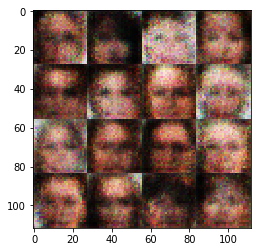

Epoch 1/1... Discriminator Loss: 1.6137... Generator Loss: 0.5251
Epoch 1/1... Discriminator Loss: 1.6175... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.6811... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.7425... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.7474... Generator Loss: 0.4754
Epoch 1/1... Discriminator Loss: 1.5589... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.5707... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.8873... Generator Loss: 0.5190


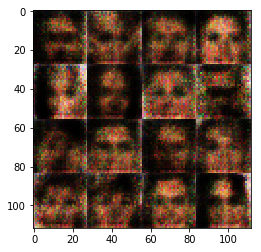

Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.6750... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.7481... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.5858... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.6853... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.5966... Generator Loss: 0.5253
Epoch 1/1... Discriminator Loss: 1.5702... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.6191... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.6287... Generator Loss: 0.5554


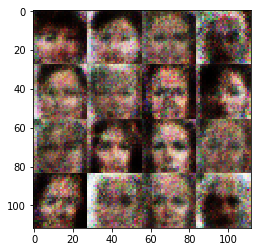

Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.6235... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.6055... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.5643... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.6685


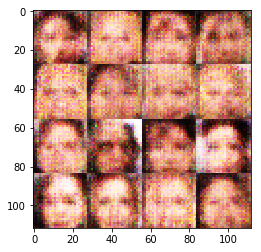

Epoch 1/1... Discriminator Loss: 1.5624... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.5638... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.6215


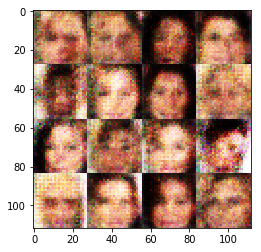

Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.5343... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 1.5589... Generator Loss: 0.6079


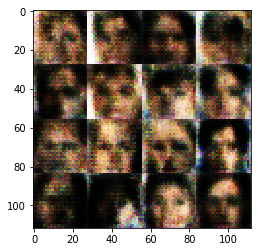

Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.5753... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.5809... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.6333


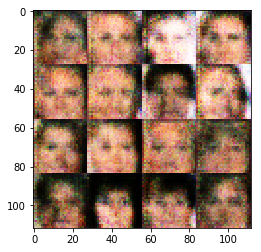

Epoch 1/1... Discriminator Loss: 1.5745... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.6539


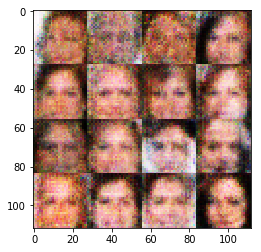

Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.5823... Generator Loss: 0.6514


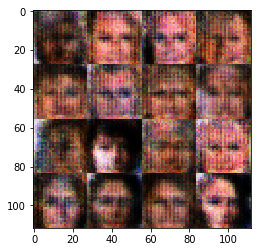

Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.6601


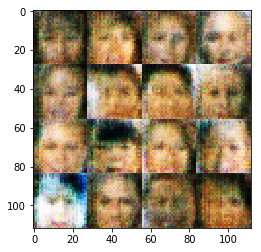

Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.6176


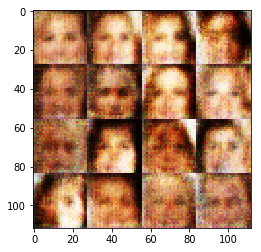

Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.5583


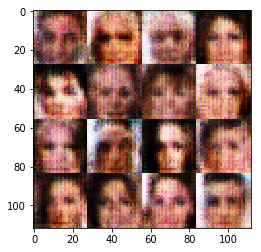

Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6295


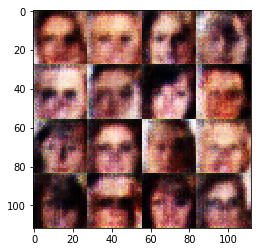

Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7088


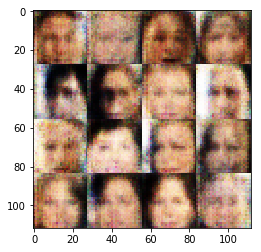

Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6316


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.